# Combining Categorical Features with Text in BERT 

By Chris McCormick

In this tutorial we'll look at the topic of classifying text with BERT, but where we also have additional numerical or categorical features that we want to use to improve our predictions. 

To help motivate our discussion, we'll be working with a dataset of about 23k clothing reviews. For each review, we have the review text, but also additional information such as:

* The age of the reviewer (numerical feature)
* The number of upvotes on the review (numerical feature)
* The department and category of the clothing item (categorical features)

For each review, we also have a binary label, which is whether or not the reviewer ultimately recommends the item. This is what we are trying to predict. 

This dataset was scraped from an (un-specified) e-commerce website by Nick Brooks and made available on Kaggle [here](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews). 

In Section 2 of this Notebook, I've implemented four different "baseline" strategies which score fairly well, but which don't incorporate all of the features together. 

Then, in Section 3, I've implemented a simple strategy to combine *everything* and feed it through BERT. Specifically, I make text out of the additional features, and prepend this text to the review. 

There is a GitHub project called the [Multimodal-Toolkit](https://github.com/georgian-io/Multimodal-Toolkit) which is how I learned about this clothing review dataset. The toolkit implements a number of more complicated techniques, but their benchmarks (as well as our results below) show that this simple features-to-text strategy works best for this dataset.

In our weekly discussion group, I talked through this Notebook and we also met with Ken Gu, the author of the Multi-Modal Toolkit! You can watch the recording [here](https://youtu.be/XPt9pIpe1vo).


# Contents

See "Table of contents" in the sidebar to the left.

# S1. Clothing Review Dataset


## 1.1. Download & Parse

Retrieve the .csv file for the dataset.

In [ ]:
import gdown

print('Downloading dataset...\n')
     
# Download the file.
gdown.download('https://drive.google.com/uc?id=1ZYdt0zN4LjWqP3cQDblNhXjeohcryY5H', 
                'Womens Clothing E-Commerce Reviews.csv', 
                quiet=False)
    
print('\n\nDONE.')

Downloading...
From: https://drive.google.com/uc?id=1ZYdt0zN4LjWqP3cQDblNhXjeohcryY5H
To: /content/Womens Clothing E-Commerce Reviews.csv
8.48MB [00:00, 48.7MB/s]



DONE.


Parse the dataset csv file into a pandas DataFrame.

In [ ]:
import pandas as pd

data_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col=0)

data_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


*Features*

"**Recommended IND**" is the label we are trying to predict for this dataset. "1" means the reviewer recommended the product and "0" means they do not.

The following are *categorical* features:

* Division Name
* Department Name
* Class Name
* Clothing ID

And the following are *numerical* features:

* Age
* Rating
* Positive Feedback Count



*Feature Analysis*

There is an excellent Notebook on Kaggle [here](https://www.kaggle.com/bhaveshkumar2806/complete-eda-and-visualization-of-text-data) which does some thorough analysis on each of the features in this dataset. 

Note that, in addition to the "Recommended" label, there is also a "**Rating**" column where the reviewer rates the product from 1 - 5. The analysis in the above Notebook shows that almost all items rated 3 - 5 are recommended, and almost all rated 1 - 2 are not recommended. We'll see in our second baseline classifier that you can get a very high accuracy with this feature alone. However, it *is* still possible to do better by incorporating the other features!



## 1.2. Train-Validation-Test Split

I want to use the same training, validation, and test splits for all of the approaches we try so that it's a fair comparison. 

However, different approaches are going to require different transformations on the data, and for simplicity I want to apply those transformations *before* splitting the dataset. 

To solve this, we're going to create lists of indeces for each of the three portions. That way, for a given classification approach, we can load the whole dataset, apply our transformations, and then split it according to these pre-determined indeces. 


In [ ]:
import random
import numpy as np

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(data_df))
val_size = int(0.1 * len(data_df))
test_size = len(data_df) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(data_df))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(data_df))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 18,788
Validation size: 2,348
      Test size: 2,350


# S2. Baseline Strategies

The following are some alternative approaches to classifying this dataset, none of which uses all of the features together. I've included these baselines to ensure that our final BERT-based approach outperforms them!




## 2.1. Always Recommend

This dataset is heavily imbalanced, with something like 85% of the reviews recommending the product. If we just predict "recommend" for every test sample, how would we do? 

In [ ]:
from sklearn.metrics import f1_score

# Select the test set samples.
test_df = data_df.iloc[test_idx]

# Create a list of all 1s to use as our predictions.
predictions = [1]*len(test_df)

# Calculate the F1 score.
f1 = f1_score(y_true=test_df["Recommended IND"], y_pred=predictions)

print('If we always recommend the product...')
print('\nF1: %.3f' % f1)

If we always recommend the product...

F1: 0.906


We'll keep a running table of our results:

| Strategy                             | F1 Score |
|--------------------------------------|----------|
| Always predict “recommended”         | 0.906    |


## 2.2. Threshold on Rating


As I mentioned earlier, the "Rating" is a very strong indicator of whether the reviewer recommended the product or not. The ideal threshold is a rating of 3.

In [ ]:
from sklearn.metrics import f1_score

# Predict whether it's recommended based on whether the rating was 3 or higher.
predictions = test_df["Rating"] >= 3

# Calculate the F1 score.
f1 = f1_score(y_true=test_df["Recommended IND"], y_pred=predictions)

print('Recommend if rating >= 3...')
print('\nF1: %.3f' % f1)

Recommend if rating >= 3...

F1: 0.953


That's very high! We can still do better, though :)

| Strategy                             | F1 Score |
|--------------------------------------|----------|
| Always predict “recommended”         | 0.906    |
| Predict “recommended” if rating >= 3 | 0.953    |


## 2.3. XGBoost

When dealing with mixed data types like this, decision trees are the standard solution, with "gradient boosted decision trees" (XGBoost) being the most common model.

In a decision tree, the classification decision is broken up into many smaller decisions (at each node of the tree). Each of these smaller decisions can operate on a different data type, enabling a mix of data types in the classifier. 

However, a decision tree can't take in raw text. So let's use a decision tree to do our predictions based only on the *non-text* features in this dataset.

Install `xgboost`

In [ ]:
!pip install xgboost

**Encode Categories**

We'll need to encode all of our categorical features by assigning an integer value to each possible category, and replacing the string versions with these integers. 

The below code / approach comes from this [article](https://pbpython.com/categorical-encoding.html).

In [ ]:
# First, change the type of the specified columns to "category". This will 
# assign a "code" to each unique category value.
data_df["Clothing ID"] = data_df["Clothing ID"].astype('category')
data_df["Division Name"] = data_df["Division Name"].astype('category')
data_df["Department Name"] = data_df["Department Name"].astype('category')
data_df["Class Name"] = data_df["Class Name"].astype('category')

# Second, replace the strings with their code values.
data_df["Clothing ID"] = data_df["Clothing ID"].cat.codes
data_df["Division Name"] = data_df["Division Name"].cat.codes
data_df["Department Name"] = data_df["Department Name"].cat.codes
data_df["Class Name"] = data_df["Class Name"].cat.codes

# Display the table--notice how the above columns are all integers now.
data_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,2,2,5
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,0,1,3
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,0,1,3
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,1,0,13
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,0,4,0


**Convert Numerical Features to Floats**

To clarify to XGBoost which features are categorical vs. numerical, I'm casting all of the numerical features to floats.

There may be another way to do this, but this appears to work fine.

In [ ]:
# Cast the numerical features to floats.
data_df["Age"] = data_df["Age"].astype('float')
data_df["Rating"] = data_df["Rating"].astype('float')
data_df["Positive Feedback Count"] = data_df["Positive Feedback Count"].astype('float')

data_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33.0,NaN,Absolutely wonderful - silky and sexy and comf...,4.0,1,0.0,2,2,5
1,1080,34.0,NaN,Love this dress! it's sooo pretty. i happene...,5.0,1,4.0,0,1,3
2,1077,60.0,Some major design flaws,I had such high hopes for this dress and reall...,3.0,0,0.0,0,1,3
3,1049,50.0,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,1,0.0,1,0,13
4,847,47.0,Flattering shirt,This shirt is very flattering to all due to th...,5.0,1,6.0,0,4,0


**Prepare Splits**


Now that the dataset is prepared, we'll break it into our training, validation, and test splits using the pre-computed indeces from earlier. (Note: the validation set is unused for XGBoost).

In [ ]:
# Retrieve the labels for each of the splits.
y_train = data_df["Recommended IND"].iloc[train_idx]
y_val = data_df["Recommended IND"].iloc[val_idx]
y_test = data_df["Recommended IND"].iloc[test_idx]

# Before selecting the inputs, remove text columns and the labels.
data_df = data_df.drop(columns=["Title", "Review Text", "Recommended IND"])

# Select the inputs for the different splits.
X_train = data_df.iloc[train_idx]
X_val = data_df.iloc[val_idx]
X_test = data_df.iloc[test_idx]

X_train.head()

,Clothing ID,Age,Rating,Positive Feedback Count,Division Name,Department Name,Class Name
14550,862,41.0,5.0,0.0,0,4,8
14421,1078,36.0,5.0,0.0,1,1,3
11316,873,38.0,5.0,0.0,0,4,8
19075,1086,38.0,4.0,1.0,0,1,3
1318,836,59.0,3.0,16.0,0,4,0


**Train & Test**



I referenced [this article](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/) to get started with XGBoost. The xgboost library makes it pretty easy! 


In [ ]:
from xgboost import XGBClassifier

# Create an instance of the classifier
model = XGBClassifier()

# Train it on the training set.
model.fit(X_train, y_train)

# Use the trained model to predict the labels for the test set.
predictions = model.predict(X_test)

# Calculate the F1 score.
f1 = f1_score(y_true = y_test,
              y_pred = predictions)

print('Using XGBoost on non-text features...')
print('\nF1: %.3f' % f1)

Using XGBoost on non-text features...

F1: 0.965


Nice! XGBoost was able to leverage the other features to outperform the simple threshold method.

> Side note: Judging by the analysis in that other Notebook, you might be able to take this further by calculating some additional features from the text. For example, the number of words in the review text appears to correlate with the recommendation.

| Strategy                             | F1 Score |
|--------------------------------------|----------|
| Always predict “recommended”         | 0.906    |
| Predict “recommended” if rating >= 3 | 0.953    |
| XGBoost                              | 0.965    |


**Feature Importance**

There are some techniques for assessing how valuable XGBoost thinks each of these features is.

Below is a built-in method for this.

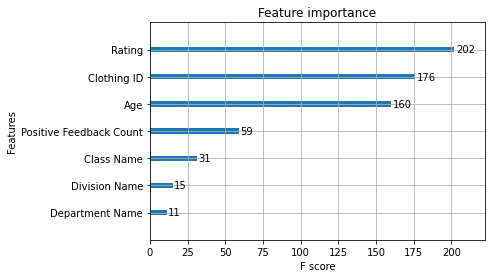

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)

pyplot.show()

This shows "Rating" as the strongest feature, which aligns with our understanding. 

This [article](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7) recommends looking specifically at "gain" as the best measure of feature importance. 


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

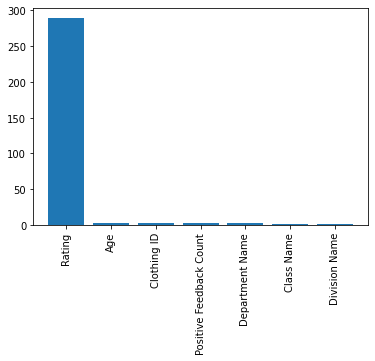

In [ ]:
feat_gains = model.get_booster().get_score(importance_type="gain")

pyplot.bar(feat_gains.keys(), feat_gains.values())
pyplot.xticks(rotation = 90)

This is a pretty different perspective! Again "Rating" is given a lot of weight, but this suggests that the other features aren't particularly useful. 

I'd have to dig more to try and understand the differences in these plots. Another approach to this analysis would be to simply drop individual features to see how much each one impacts the accuracy.

## 2.4. BERT on Review Text Only

For our final baseline, we can try applying BERT to just the review text, and ignoring all of the other features. 

To run this experiment, you can modify Section 3.1. to just use the review text. 

I ran this experiment and got an F1 score of `0.945`. That's a good score, but clearly we'd do better if we could incorporate the non-text features!

| Strategy                             | F1 Score |
|--------------------------------------|----------|
| Always predict “recommended”         | 0.906    |
| Predict “recommended” if rating >= 3 | 0.953    |
| XGBoost                              | 0.965    |
| BERT on review text                  | 0.945    |


# S3. BERT with All Features

## 3.1. All Features to Text

The simplest way to handle these non-text features is to convert them into text and concatenate them with the review text!

I figured that BERT would make better use of these additional features given some additional context... For example, to handle the "Age" feature, instead of just prepending the number "33" on its own, I prepend the text "I am 33 years old."

> UPDATE: I learned from Ken that they simply added the features as strings separated by the “[SEP]” token (e.g., “Dresses [SEP] General [SEP] 34 [SEP] 5 …”) Ken’s approach achieved the same test set score in their experiments, and saves significantly on the sequence length!


In [ ]:
# This will hold all of the dataset samples, as strings.
sen_w_feats = []

# The labels for the samples.
labels = []

# First, reload the dataset to undo the transformations we applied for XGBoost.
data_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col=0)

# Some of the reviews are missing either a "Title" or "Review Text", so we'll 
# replace the NaN values with empty string.
data_df = data_df.fillna("")


print('Combining features into strings...')

# For each of the samples...
for index, row in data_df.iterrows():

    # Piece it together...    
    combined = ""
    
    #combined += "The ID of this item is {:}, ".format(row["Clothing ID"])
    combined += "This item comes from the {:} department and {:} division, " \
                "and is classified under {:}. ".format(row["Department Name"], 
                                                       row["Division Name"], 
                                                       row["Class Name"])
    
    combined += "I am {:} years old. ".format(row["Age"])
    
    combined += "I rate this item {:} out of 5 stars. ".format(row["Rating"])
    
    # Not all samples have titles.
    if not row["Title"] == "":
        combined += row["Title"] + ". "
    
    # Finally, append the review the text!
    combined += row["Review Text"]
    
    # Add the combined text to the list.
    sen_w_feats.append(combined)

    # Also record the sample's label.
    labels.append(row["Recommended IND"])

print('  DONE.')

print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))

Combining features into strings...
  DONE.
Dataset contains 23,486 samples.


Let's print one of the samples to see the result. The first three sentences are generated and insterted by me (in the code above), and the rest is from the original review.

In [ ]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

print(wrapper.fill(sen_w_feats[1]))

This item comes from the Dresses department and General division, and is
classified under Dresses. I am 34 years old. I rate this item 5 out of 5 stars.
Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm
glad i did bc i never would have ordered it online bc it's petite.  i bought a
petite and am 5'8".  i love the length on me- hits just a little below the knee.
would definitely be a true midi on someone who is truly petite.


## 3.2. GPU & Transformers Setup

Complete a number of standard setup tasks for BERT.

Tell PyTorch to use the GPU. 

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Install huggingface transformers.

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 7.8MB/s 
     |████████████████████████████████| 901kB 44.1MB/s 
     |████████████████████████████████| 3.3MB 47.3MB/s 


Load the tokenizer.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Load the BERT Classification model.

In [ ]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## 3.3. Training Parameters

Let's define all of our key training parameters in one section.

For the purposes of fine-tuning, the BERT authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 


In [ ]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 4

Another key parameter is our "maximum sequence length", which we will truncate or pad all of our samples to. Setting this to a higher value requires more memory and slows down training, so we want to see how short we can get away with.

We'll run a pass over the dataset to find the longest sequence and use this to inform our choice. 

In [ ]:
max_len = 0

# For every sentence...
for sent in sen_w_feats:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  204


In [ ]:
# Let's use a maximum length of 200.
max_len = 200

## 3.3. Tokenize & Encode

Now we can do the real tokenization and encoding.


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding all reviews in the dataset...')

# For every sentence...
for sent in sen_w_feats:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('DONE.')

Encoding all reviews in the dataset...
DONE.


Now that it's done, we can divide up the samples into the three splits.

In [ ]:
from torch.utils.data import TensorDataset

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels[test_idx])

## 3.4. Training

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

### 3.4.1. Setup

We'll also create an iterator for our dataset using the torch DataLoader class. The DataLoader is responsible for randomly selecting our training batches for us.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Next we need to create the optimizer, passing it the weights from our BERT model.

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

In [ ]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )


The learning rate scheduler will implement learning rate decay for us.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Define a helper function for calculating simple accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### 3.4.2. Training Loop

We're ready to kick off the training!

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    588.    Elapsed: 0:00:24.
  Batch    80  of    588.    Elapsed: 0:00:48.
  Batch   120  of    588.    Elapsed: 0:01:12.
  Batch   160  of    588.    Elapsed: 0:01:36.
  Batch   200  of    588.    Elapsed: 0:02:00.
  Batch   240  of    588.    Elapsed: 0:02:24.
  Batch   280  of    588.    Elapsed: 0:02:48.
  Batch   320  of    588.    Elapsed: 0:03:11.
  Batch   360  of    588.    Elapsed: 0:03:35.
  Batch   400  of    588.    Elapsed: 0:03:59.
  Batch   440  of    588.    Elapsed: 0:04:23.
  Batch   480  of    588.    Elapsed: 0:04:47.
  Batch   520  of    588.    Elapsed: 0:05:11.
  Batch   560  of    588.    Elapsed: 0:05:35.

  Average training loss: 0.18
  Training epcoh took: 0:05:51

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.13
  Validation took: 0:00:15

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    588.    Elapsed: 0:00:24.
  Batch    80  of    588.    Elapsed: 0:00:48.
  Batch  

### 3.4.3. Training Results

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.18,0.13,0.95,0:05:51,0:00:15
2,0.11,0.13,0.95,0:05:51,0:00:14
3,0.10,0.13,0.95,0:05:51,0:00:15
4,0.08,0.15,0.95,0:05:51,0:00:15


We can plot the training loss and validation loss to check for over-fitting.

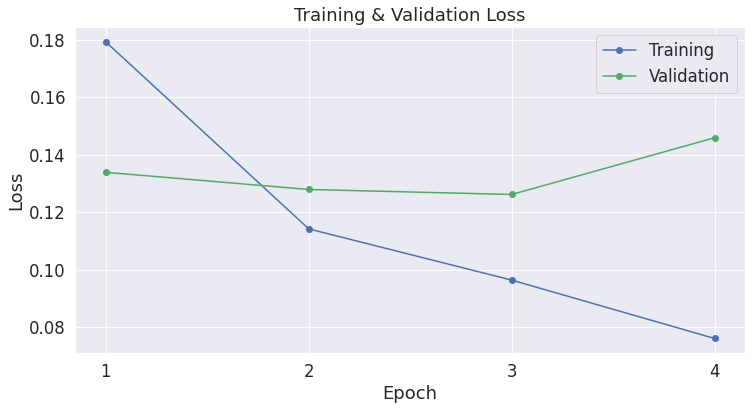

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

There does appear to be some over-fitting here. If you really wanted to go for the best accuracy, you could try saving a model checkpoint after each epoch, and see if the third checkpoint does better on the test set.

*Why Validation Loss, not Accuracy?*

Validation loss is a more precise measure than validation accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

## 3.5. Test


Now we're ready to score our trained model against the test set!

The below cell will generate all of the predictions.

In [ ]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,350 test sentences...
    DONE.


Because the test samples were processed in batches, there's a little re-arranging required to get the results back down to a simple list.

Also, the predictions are currently floating point values representing confidences, but we need to turn these into binary labels (0 or 1). 

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

Now we can score the results!

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1
f1 = f1_score(flat_true_labels, flat_predictions)

print('F1 Score: %.3f' % f1)

F1 Score: 0.968


Here are the final scores:

| Strategy                             | F1 Score |
|--------------------------------------|----------|
| Always predict “recommended”         | 0.906    |
| Predict “recommended” if rating >= 3 | 0.953    |
| XGBoost                              | 0.965    |
| BERT on review text                  | 0.945    |
| BERT, all features to text           | 0.968    |

We managed to outperform the other strategies! 

> UPDATE: One of our discussion group attendees, Jon, pointed out that (1) MCC is probably a better metric for this dataset due to the class imbalance, and (2) that it’s good practice to verify that our randomly selected test set has the same class balance as the training set (this probably happened naturally, though, given that the test set has ~2k samples).

# Conclusion

Simply converting the extra features to text seems to be a great solution for this dataset. I suspect that this is because the categorical features in this dataset can be easily converted into meaningful text that BERT can leverage. Even the rating, which is technically a numerical feature, is pretty understandable since there are only 5 possible values.

The [Multimodal-Toolkit](https://github.com/georgian-io/Multimodal-Toolkit) also includes 2 other datasets where this approach (referred to as "unimodal" in their benchmark tables) does *not* get the highest score. You could imagine how, if there are continuous-valued (floating point) features in the dataset that are highly meaningful, it could be difficult for BERT to make sense of these as text. 

So, if you just have text and categorical features, you may not need to look any farther than the simple strategy implemented in this Notebook!